In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
# setup disply parameters
import pandas as pd
import numpy as np
from rich import print
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter

float_formatter = StrMethodFormatter("{x:0.03f}")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=(18, 6))  # set figure size

## Running a Negotiation

NegMAS has several built-in negotiation `Mechanism` s, negotiation agents (`Negotiator` s), and `UtilityFunction` s. You can use these to run negotiations as follows:

In [2]:
from negmas import SAOMechanism, TimeBasedConcedingNegotiator, MappingUtilityFunction
import random  # for generating random ufuns

random.seed(0)  # for reproducibility

session = SAOMechanism(outcomes=10, n_steps=100)
negotiators = [TimeBasedConcedingNegotiator(name=f"a{_}") for _ in range(5)]
for negotiator in negotiators:
    session.add(
        negotiator,
        preferences=MappingUtilityFunction(
            lambda x: random.random() * x[0], outcome_space=session.outcome_space
        ),
    )

print(session.run())

SAOState(
    running=False,
    waiting=False,
    started=True,
    step=1,
    time=0.0023992909700609744,
    relative_time=0.019801980198019802,
    broken=True,
    timedout=False,
    agreement=None,
    results=None,
    n_negotiators=5,
    has_error=False,
    error_details='',
    threads={},
    last_thread='',
    current_offer=None,
    current_proposer=None,
    current_proposer_agent=None,
    n_acceptances=0,
    new_offers=[],
    new_offerer_agents=<class 'list'>,
    last_negotiator=None
)

Negotations end with a status that shows you what happens. In the above example, we can see that the negotiation was not broken and did not time-out. The agreement was on outcome `(9,)` of the *10* possible outcomes of this negotiation. That offer was offered by negotiator `a3` (the rest of the agent *ID* is always a random value to ensure no name repetitions) in the `9`th round of the negotiation (rounds/steps start at `0`) and was accepted by all of the other *4* negotiators. The whole negotiation took `4.66` ms.

Let's look at this code example line-by-line:

```python
session = SAOMechanism(outcomes=10, n_steps=100)
```

The negotiation protocol in NegMAS is handled by a `Mechanism` object. Here we instantiate an `SAOMechanism` which implements the [**Stacked Alternating Offers Protocol**](https://ii.tudelft.nl/~catholijn/publications/sites/default/files/Aydogan2017_Chapter_AlternatingOffersProtocolsForM.pdf). In this protocol, negotiators exchange offers until an offer is accepted by all negotiators, a negotiators leaves the table ending the negotiation or a time-out condition is met. In the example above, we use a limit on the number of rounds (defined by a number of offers equal to the number of negotiators) of `100` (a step of a mechanism is an executed round). Another possibility here is to pass a wall-time constraint using something like `time_limit=10` which limits the negotiation to `10` seconds. 

The negotiation agenda can be specified in two ways:

1. You can pass `outcomes=x` to create a negotiation agenda with a single issue of `x` values. In this example we use this approach to create a single issue negotiation with `10` outcomes. These outcomes will be tuples of one item each ranging from `(0,)` to `(9,)`.
2. You can pass `issues=x` to create a multi-issue negotiation as we will see later in this tutorial. We can use this approach to achieve the same result as above by replacing `outcomes=10` with `issues=[make_issue(10)]` in the sample code above.

```python
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
```

This line creates `5` negotiators of the type `AspirationNegotiator` which implements a simple time-based negotiation strategy. It starts by offering the outcome with maximum utility for itself and then concedes (i.e. offers outcomes with lower utility) based on the relative time of the negotiation.

```python
for negotiator in negotiators:
    session.add(negotiator, preferences=MappingUtilityFunction(lambda x: random.random() * x[0]))
```

This loop *adds* the negotiators to the negotiation session (the `SAOMechanism` we created earlier). Most negotiators need access to a utility function that defines its preferences over different outcomes. Here we use a `MappintUtilityFunction` which is passed any python callable (i.e. a function, lambda expression, a class implementing `__call__`, ...) and uses it to calculate the utility of a given outcome. 

The lambda expression used here (`lambda x: random.random() * x[0]`) extracts the first value of the outcome (which will be an integer from `0` to `9`) and multiplies it with a random number *each time it is called*. This means that calling this utility function twice with the same outcome results in two different values. This may not be particularly useful but it shows that the utility function can *change* during the negotiation and NegMAS provides some support for this which we will discuss in later tutorials.

Now the last line runs the negotiation using the `run()` method of the `SAOMechanism` object, converts the result to a dictionary using `var` and prints it. 

### A simple bilateral negotiation

Let's try a more meaningful situation:
Assume we have a buyer and a seller who are negotiating about a business transaction in which the buyer wants to maximize his profit while the seller wants to minimize her cost. They both would like to transact on as much as possible of the product and each has some preferred delivery time.

This can be modeled in the following negotiation:


In [3]:
from negmas import (
    make_issue,
    SAOMechanism,
    NaiveTitForTatNegotiator,
    TimeBasedConcedingNegotiator,
)
from negmas.preferences import LinearAdditiveUtilityFunction as LUFun
from negmas.preferences.value_fun import LinearFun, IdentityFun, AffineFun

# create negotiation agenda (issues)
issues = [
    make_issue(name="price", values=10),
    make_issue(name="quantity", values=(1, 11)),
    make_issue(name="delivery_time", values=10),
]

# create the mechanism
session = SAOMechanism(issues=issues, n_steps=20)

# define buyer and seller utilities
seller_utility = LUFun(
    values=[IdentityFun(), LinearFun(0.2), AffineFun(-1, bias=9.0)],
    outcome_space=session.outcome_space,
)

buyer_utility = LUFun(
    values={
        "price": AffineFun(-1, bias=9.0),
        "quantity": LinearFun(0.2),
        "delivery_time": IdentityFun(),
    },
    outcome_space=session.outcome_space,
)

# create and add buyer and seller negotiators
session.add(TimeBasedConcedingNegotiator(name="buyer"), preferences=buyer_utility)
session.add(TimeBasedConcedingNegotiator(name="seller"), ufun=seller_utility)

# run the negotiation and show the results
print(session.run())

SAOState(
    running=False,
    waiting=False,
    started=True,
    step=18,
    time=0.0057805420365184546,
    relative_time=0.9047619047619048,
    broken=False,
    timedout=False,
    agreement=(1, 9, 0),
    results=None,
    n_negotiators=2,
    has_error=False,
    error_details='',
    threads={},
    last_thread='',
    current_offer=(1, 9, 0),
    current_proposer='seller-8bc36403-7be3-4374-9086-a860e1ae2df7',
    current_proposer_agent=None,
    n_acceptances=2,
    new_offers=[],
    new_offerer_agents=[None, None],
    last_negotiator='seller'
)

In this run, we can see that the agreement was on a high price (*9*) which is preferred by the seller but with a delivery time of *8* which is preferred by the buyer. Negotiation took *17* steps out of the allowed *20* (*90%* of the available time)


We can check the negotiation history as well by printing the `extended_trace` which shows the step, negotiator, and offer for every s tep of the negotiation:


In [4]:
session.extended_trace

[(0, 'buyer-5c76fbe1-c1b3-4958-9f9d-a5409d2e1197', (0, 11, 9)),
 (0, 'seller-8bc36403-7be3-4374-9086-a860e1ae2df7', (9, 11, 0)),
 (1, 'buyer-5c76fbe1-c1b3-4958-9f9d-a5409d2e1197', (0, 11, 9)),
 (1, 'seller-8bc36403-7be3-4374-9086-a860e1ae2df7', (9, 11, 0)),
 (2, 'buyer-5c76fbe1-c1b3-4958-9f9d-a5409d2e1197', (0, 11, 9)),
 (2, 'seller-8bc36403-7be3-4374-9086-a860e1ae2df7', (9, 11, 0)),
 (3, 'buyer-5c76fbe1-c1b3-4958-9f9d-a5409d2e1197', (0, 11, 9)),
 (3, 'seller-8bc36403-7be3-4374-9086-a860e1ae2df7', (9, 11, 0)),
 (4, 'buyer-5c76fbe1-c1b3-4958-9f9d-a5409d2e1197', (0, 11, 9)),
 (4, 'seller-8bc36403-7be3-4374-9086-a860e1ae2df7', (9, 11, 0)),
 (5, 'buyer-5c76fbe1-c1b3-4958-9f9d-a5409d2e1197', (0, 11, 9)),
 (5, 'seller-8bc36403-7be3-4374-9086-a860e1ae2df7', (9, 11, 0)),
 (6, 'buyer-5c76fbe1-c1b3-4958-9f9d-a5409d2e1197', (0, 10, 9)),
 (6, 'seller-8bc36403-7be3-4374-9086-a860e1ae2df7', (9, 10, 0)),
 (7, 'buyer-5c76fbe1-c1b3-4958-9f9d-a5409d2e1197', (0, 9, 9)),
 (7, 'seller-8bc36403-7be3-4374-90

We can even plot the complete negotiation history and visually see how far were the result from the pareto frontier (it was 0.0 utility units far from it). 

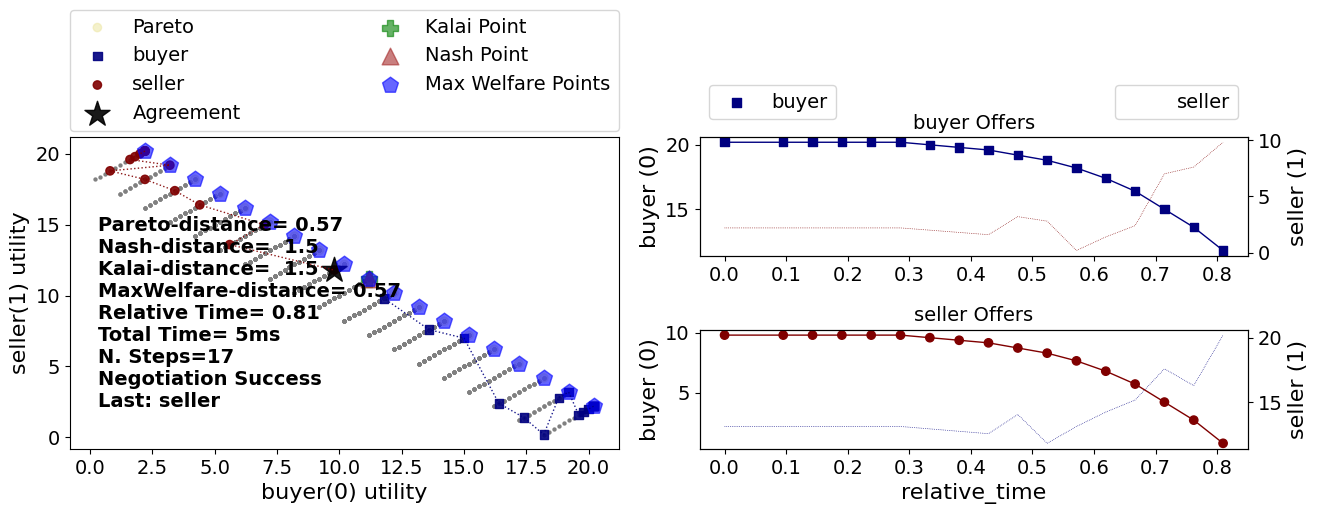

In [5]:
session.plot(show_reserved=False)
plt.show()

What happens if the seller was much more interested in delivery time. 

Firstly, what do you expect? 

Given that delivery time becomes a more important issue now, the seller will get more utility points by allowing the price to go down given that the delivery time can be made earlier. This means that we should expect the delivery time and price to go down. Let's see what happens:

In [6]:
seller_utility = LUFun(
    values={
        "price": IdentityFun(),
        "quantity": LinearFun(0.2),
        "delivery_time": AffineFun(-1, bias=9),
    },
    weights={"price": 1.0, "quantity": 1.0, "delivery_time": 10.0},
    outcome_space=session.outcome_space,
)

session = SAOMechanism(issues=issues, n_steps=50)
session.add(TimeBasedConcedingNegotiator(name="buyer"), ufun=buyer_utility)
session.add(TimeBasedConcedingNegotiator(name="seller"), ufun=seller_utility)
print(session.run())

SAOState(
    running=False,
    waiting=False,
    started=True,
    step=41,
    time=0.007554874988272786,
    relative_time=0.8235294117647058,
    broken=False,
    timedout=False,
    agreement=(1, 10, 3),
    results=None,
    n_negotiators=2,
    has_error=False,
    error_details='',
    threads={},
    last_thread='',
    current_offer=(1, 10, 3),
    current_proposer='seller-c6393529-15a1-4ae4-871d-9b74be353336',
    current_proposer_agent=None,
    n_acceptances=2,
    new_offers=[],
    new_offerer_agents=[None, None],
    last_negotiator='seller'
)

We can check it visually as well:

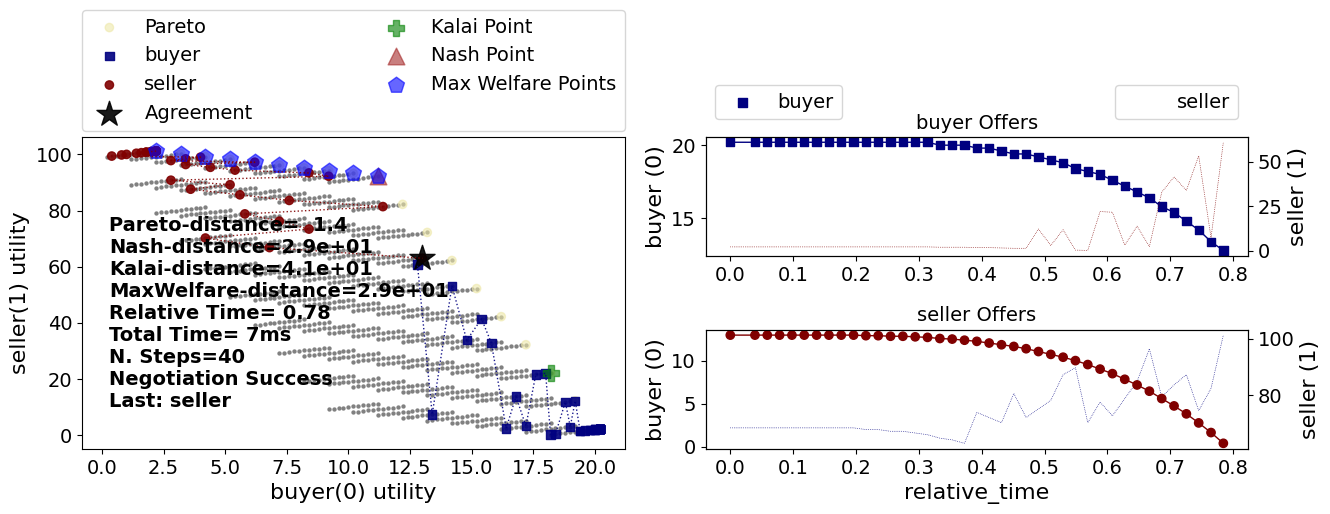

In [7]:
session.plot(show_reserved=False)
plt.show()

It is clear that the new ufuns transformed the problem. Now we have many outcomes that are far from the pareto-front in this case. Nevertheless, there is money on the table as the negotiators did not agree on an outcome on the pareto front.

Inspecting the utility ranges of the seller and buyer we can see that the seller can get much higher utility than the buyer (100 comapred with 20). This is a side effect of the ufun definitions and we can remove this difference by normalizing both ufuns and trying again:

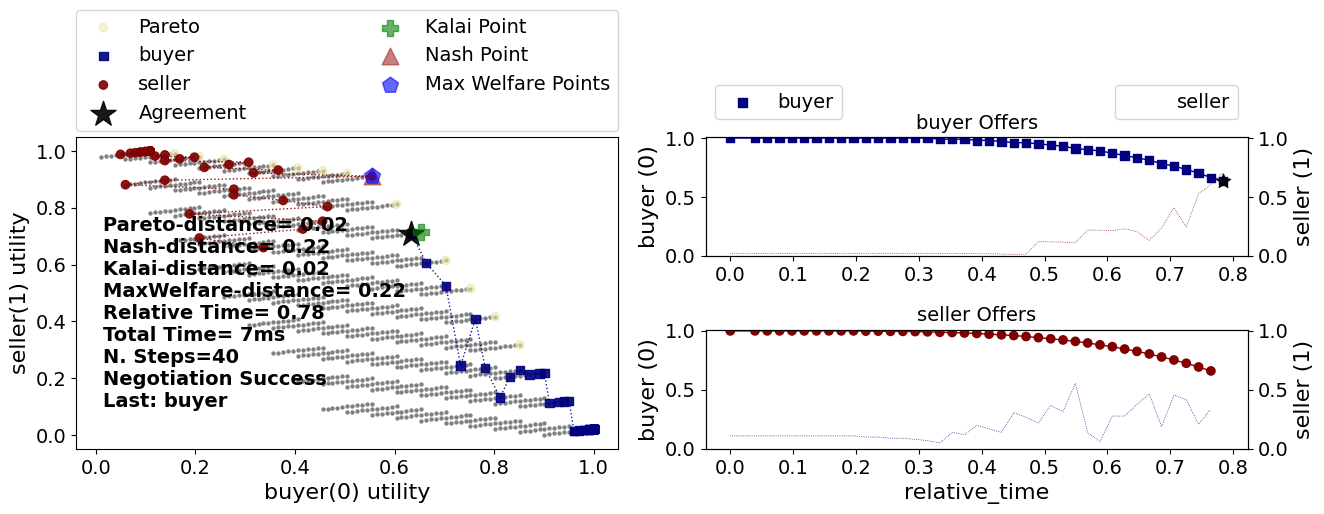

In [8]:
seller_utility = seller_utility.scale_max(1.0)
buyer_utility = buyer_utility.scale_max(1.0)
session = SAOMechanism(issues=issues, n_steps=50)
session.add(TimeBasedConcedingNegotiator(name="buyer"), ufun=buyer_utility)
session.add(TimeBasedConcedingNegotiator(name="seller"), ufun=seller_utility)
session.run()
session.plot(ylimits=(0.0, 1.01), show_reserved=False)
plt.show()

What happens if we give them more time to negotiate:

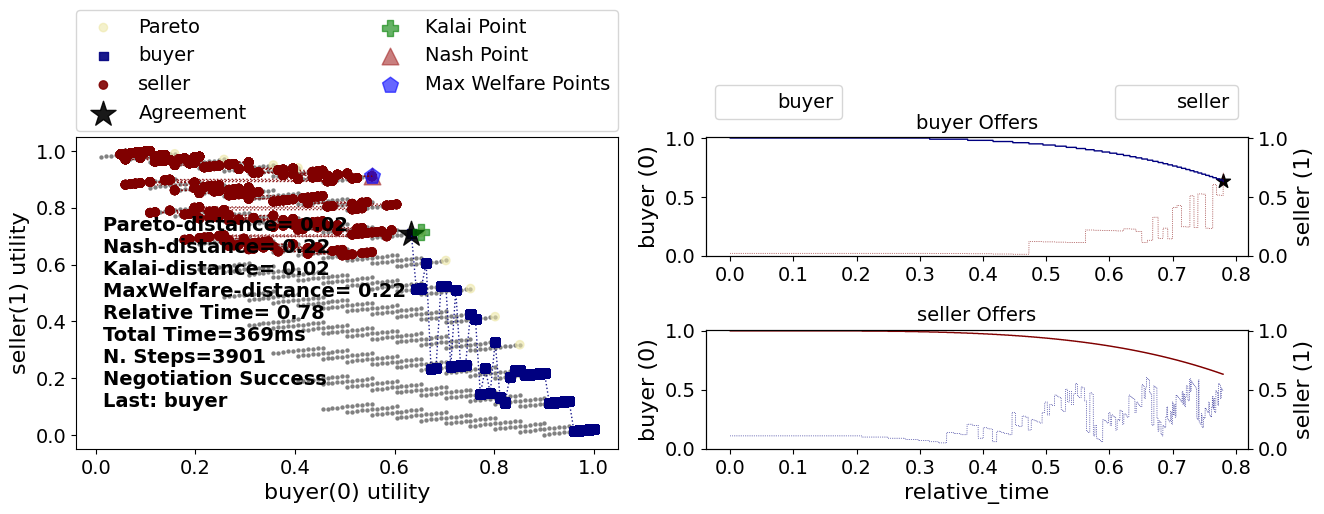

In [9]:
session = SAOMechanism(issues=issues, n_steps=5000)

session.add(TimeBasedConcedingNegotiator(name="buyer"), ufun=buyer_utility)
session.add(TimeBasedConcedingNegotiator(name="seller"), ufun=seller_utility)
session.run()
session.plot(ylimits=(0.0, 1.01), show_reserved=False)
plt.show()

It did not help much! The two agents adjusted their concession to match the new time and they did not get to the Pareto-front. 

Let's allow them to concede faster by setting their `aspiration_type` to *linear* instead of the default *boulware*:


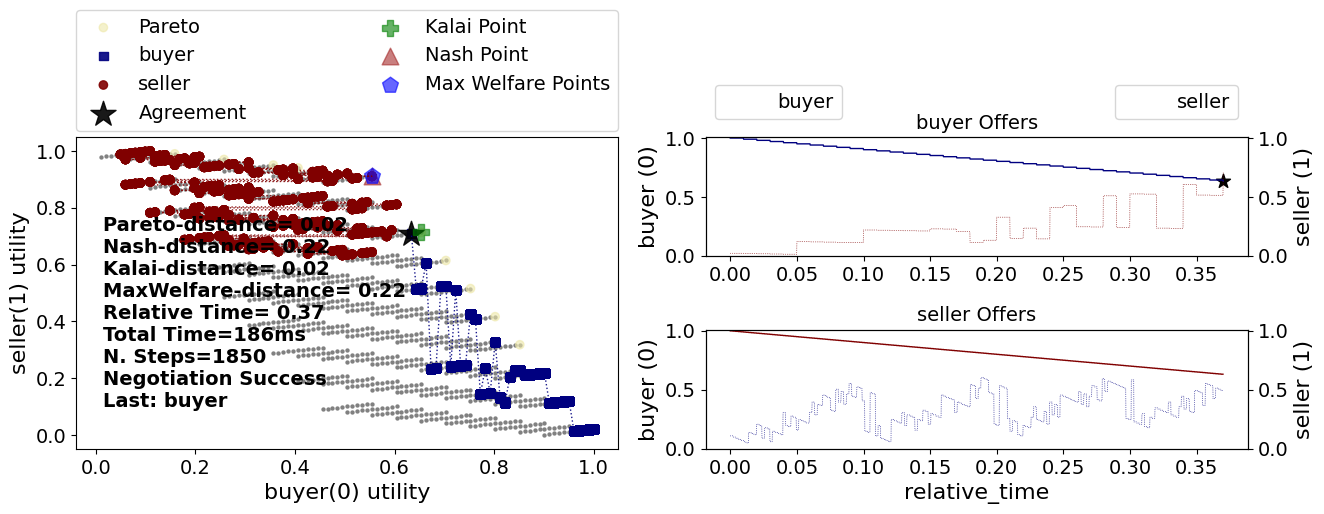

In [10]:
session = SAOMechanism(issues=issues, n_steps=5000)
session.add(
    TimeBasedConcedingNegotiator(name="buyer", offering_curve="linear"),
    ufun=buyer_utility,
)
session.add(
    TimeBasedConcedingNegotiator(name="seller", offering_curve="linear"),
    ufun=seller_utility,
)
session.run()
session.plot(ylimits=(0.0, 1.01), show_reserved=False)
plt.show()

It is clear that longer negotiation time, and faster concession did not help the negotiators get to a point on the pareto-front. 

What happens if one of the negotiators (say the buyer) was tougher than the other?

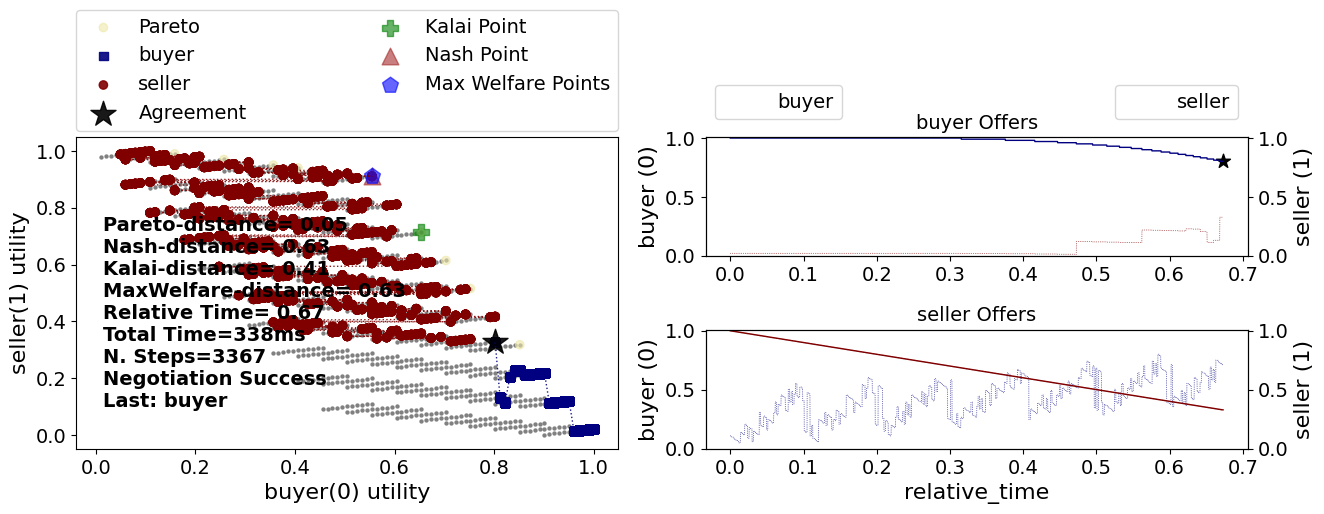

In [11]:
session = SAOMechanism(issues=issues, n_steps=5000)
session.add(
    TimeBasedConcedingNegotiator(name="buyer", offering_curve="boulware"),
    ufun=buyer_utility,
)
session.add(
    TimeBasedConcedingNegotiator(name="seller", offering_curve="linear"),
    ufun=seller_utility,
)
session.run()
session.plot(ylimits=(0.0, 1.01), show_reserved=False)
plt.show()

Try to give an intuition for what happened:
    
- Why did the negotiation take shorter than the previous one?
- Why is the final agreement nearer to the pareto front?
- Why is the buyer getting higher utility than in the case before the previous (in which it was also using a Boulware strategy)?
- Why is the seller getting lower utility than in the case before the previous (in which it was also using a linear concession strategy)?
- If the seller knew that the buyer will be using this strategy, what is its best response?